In [1]:
%pip install faiss-gpu

In [56]:
import glob
import os
import random

import faiss
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torchvision import models, transforms


In [77]:
IMAGE_DB_PATH = "/root/AIVN-materials/pretrained/data/ll_classes/train"
PRETRAINED_MODEL = "/root/AIVN-materials/pretrained/mobilenetv2.pt"
TEST_DB_PATH = "/root/AIVN-materials/pretrained/data/ll_classes/test"

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5071, 0.4867, 0.4408),
                        std=(0.2675, 0.2565, 0.2761))
])

# model = models.mobilenet_v2(pretrained=True)
model = models.mobilenet_v2(pretrained=False, num_classes=30)
state_dict = torch.load(PRETRAINED_MODEL)
state_dict = {k.partition('model.')[2]:state_dict[k] for k in state_dict.keys()}
model.load_state_dict(state_dict, strict=False)
model.classifier = nn.Identity()    # remove the last layer
model = model.to("cuda")
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [78]:
faiss_index = faiss.IndexFlatL2(1280)   # build the index

im_indices = []
with torch.no_grad():
    for f in glob.glob(os.path.join(IMAGE_DB_PATH, '*/*')):
        im = Image.open(f)
        im = torch.tensor([transform(im).numpy()]).cuda()
    
        preds = model(im)
        preds = np.array([preds[0].cpu().numpy()])
        faiss_index.add(preds) #add the representation to index
        im_indices.append(f)   #store the image name to find it later on

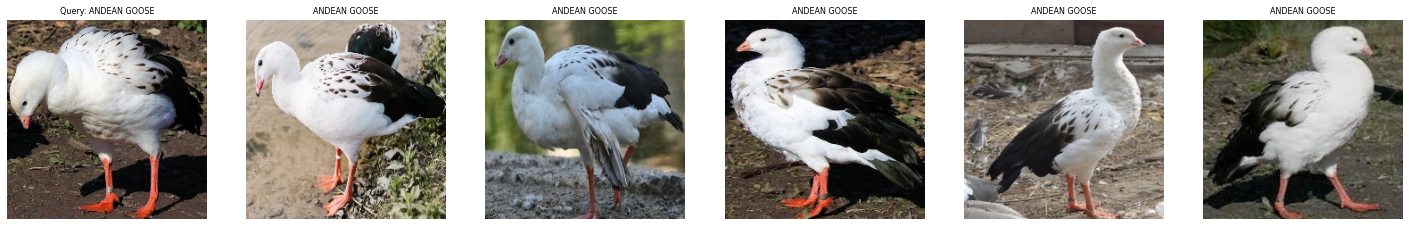

In [83]:
query_image_path = random.choice(glob.glob(os.path.join(TEST_DB_PATH, '*/*')))
with torch.no_grad():
    im = Image.open(query_image_path)
    im = im.resize((224,224))
    im = torch.tensor([transform(im).numpy()]).cuda()

    test_embed = model(im).cpu().numpy()
    _, I = faiss_index.search(test_embed, 5)


# Plot resultsd
fig, axes = plt.subplots(1, 6, figsize=(25, 60))

image = Image.open(query_image_path)
ax = axes.flat[0]
ax.tick_params(axis='x', labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.axis('off')
ax.imshow(image)
class_name = os.path.basename(os.path.dirname(query_image_path))
ax.set_title(f"Query: {os.path.basename(os.path.dirname(query_image_path))}", fontsize=8)

i = 1
for index in I[0]:
    image_path = im_indices[index]
    image = Image.open(image_path)
    ax = axes.flat[i]
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.axis('off')
    i += 1
    ax.imshow(image)
    ax.set_title(f"{os.path.basename(os.path.dirname(image_path))}", fontsize=8)
fig.show()
